# Denoising

In this simple notebook, we look at a denoising problem and how the linearized bregman iterations provide a simple and efficient solution.

# Packages setup

In [1]:
# ] registry add https://github.com/slimgroup/SLIMregistryJL.git
# ] add LinearAlgebra, JOLI, TestImages, ImageView

In [2]:
using SlimOptim, LinearAlgebra, JOLI, TestImages, PyPlot
import TestImages: Gray

# Use a standard reference image

In [3]:
n = 128
k = 4
n1, n2 = k*n, n
img = Float32.(testimage("moonsurface.png"))
img = img[1:2:end, 1:2:end];

┌ Warning: "moonsurface.png" not found in `TestImages.remotefiles`. Load "moonsurface.tiff" instead.
└ @ TestImages ~/.julia/packages/TestImages/1zo60/src/TestImages.jl:163


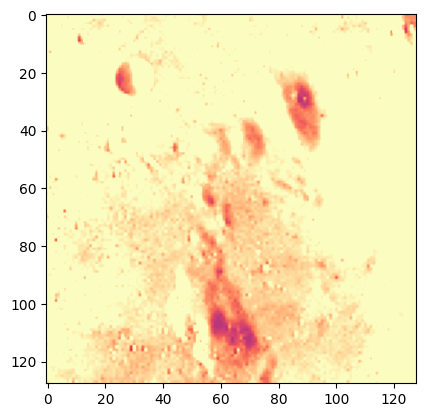

In [4]:
imshow(img, cmap="magma", vmin=-.5, vmax=.5);

# Measurment operator

In [5]:
A = vcat([joRomberg(n, n; DDT=Float32, RDT=Float32) for i=1:k]...);

# Setup transform domain operator

In [6]:
# Sparse in wavelet domain
W = joDWT(n, n; DDT=Float32, RDT=Float32);
# Or with curvelet ifi nstalled
# W = joCurvelet2D(128, 128; DDT=Float32, RDT=Float32);

# Measurements

In [7]:
# Make noisy data
b = A*vec(img);
b += .01f0*randn(Float32, size(b));

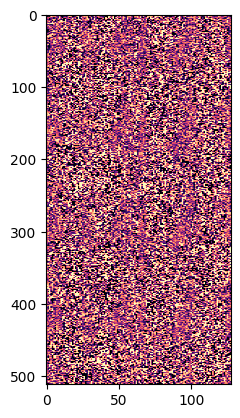

PyObject <matplotlib.image.AxesImage object at 0x15a768810>

In [8]:
imshow(reshape(b, n1, n2), cmap="magma", vmin=-.5, vmax=.5, aspect=.5)

# Linearized bregman

We solve the following l1-l2 optimization problem:

$$
\begin{align}
\min_x & \ \ \lambda || W x||_1 + \frac{1}{2} ||W x ||_2^2 \\
          & \text{s.t. } Ax = b
\end{align}
$$

where $W$ is the sparsity promoting transform, $x$ is the unknown image and $A$ is a tall measuremment operator.

In [9]:
# setup bregman
opt = bregman_options(maxIter=200, verbose=2, quantile=.5, antichatter=true, spg=true)

SlimOptim.BregmanParams(2, 1.0e-8, 200, false, true, 0.5, true, UniformScaling{Bool}(true), SlimOptim.var"#35#38"{Int64}(Core.Box(SlimOptim.var"#34#37"{Float64}(0.5)), 1), nothing)

In [10]:
sol = bregman(A, W, zeros(Float32, n*n), b, opt);

Running linearized bregman...
Progress tolerance: 1.00e-08


┌ Warning: deprecation warning: please put TD in options (BregmanParams) for version > 0.1.7; now overwritting TD in BregmanParams
└ @ SlimOptim ~/.julia/dev/SlimOptim/src/bregman.jl:88


Maximum number of iterations: 200
Anti-chatter correction: 1
 Iteration     Step Length        L1-2     ||A*x - b||_2^2     λ
         1             NaN     0.00000e+00     8.62052e+03     1.34803e-06 
         2     2.49999e-01     7.31164e-06     8.61953e+03     1.34803e-06 
         3     2.50000e-01     2.15437e+03     2.42224e+00     1.34803e-06 
         4     2.50122e-01     2.15439e+03     2.42225e+00     1.34803e-06 
         5     2.26376e-01     2.15439e+03     2.42225e+00     1.34803e-06 
         6     2.12187e-01     2.15439e+03     2.42225e+00     1.34803e-06 
         7     2.20533e-01     2.15439e+03     2.42225e+00     1.34803e-06 
         8     2.23766e-01     2.15439e+03     2.42225e+00     1.34803e-06 
         9     2.38927e-01     2.15439e+03     2.42225e+00     1.34803e-06 
        10     2.14379e-01     2.15439e+03     2.42225e+00     1.34803e-06 
        11     2.34470e-01     2.15439e+03     2.42225e+00     1.34803e-06 
        12     2.15027e-01     2.15439

# Plot result and convergence

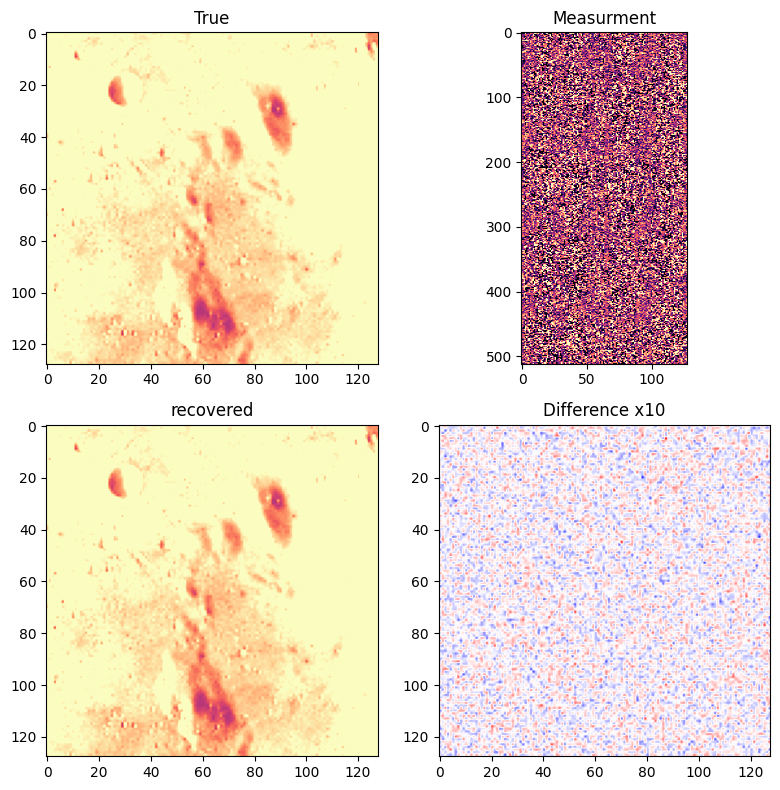

In [11]:
figure(figsize=(8,8));
subplot(221)
imshow(img, cmap="magma", vmin=-.5, vmax=.5)
title("True")
subplot(222)
imshow(reshape(b, n1, n2), cmap="magma", vmin=-.5, vmax=.5, aspect=.5)
title("Measurment")
subplot(223)
imshow(reshape(sol.x, n, n), cmap="magma", vmin=-.5, vmax=.5)
title("recovered")
subplot(224)
imshow(img - reshape(sol.x, n, n), cmap="seismic", vmin=-.5e-1, vmax=.5e-1)
title("Difference x10")
tight_layout()

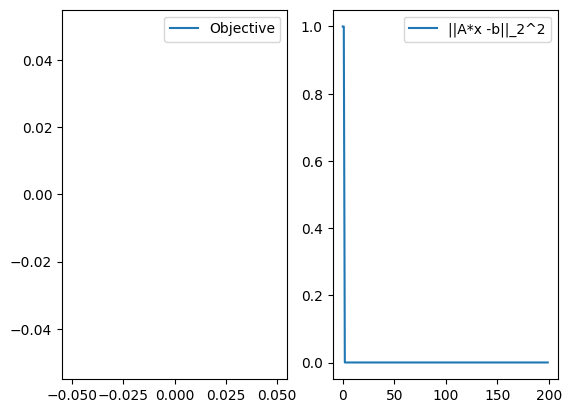

PyObject <matplotlib.legend.Legend object at 0x15d263310>

In [12]:
figure()
subplot(121)
plot(sol.ϕ_trace/sol.ϕ_trace[1], label="Objective")
legend()
subplot(122)
plot(sol.r_trace/sol.r_trace[1], label="||A*x -b||_2^2")
legend()